In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

Reinforcement Learning (PPO) with TorchRL Tutorial
==================================================

**Author**: [Vincent Moens](https://github.com/vmoens)

This tutorial demonstrates how to use PyTorch and
:py`torchrl`{.interpreted-text role="mod"} to train a parametric policy
network to solve the Inverted Pendulum task from the
[OpenAI-Gym/Farama-Gymnasium control
library](https://github.com/Farama-Foundation/Gymnasium).

![Inverted
pendulum](https://pytorch.org/tutorials/_static/img/invpendulum.gif)

Key learnings:

-   How to create an environment in TorchRL, transform its outputs, and
    collect data from this environment;
-   How to make your classes talk to each other using
    `~tensordict.TensorDict`{.interpreted-text role="class"};
-   The basics of building your training loop with TorchRL:
    -   How to compute the advantage signal for policy gradient methods;
    -   How to create a stochastic policy using a probabilistic neural
        network;
    -   How to create a dynamic replay buffer and sample from it without
        repetition.

We will cover six crucial components of TorchRL:

-   [environments](https://pytorch.org/rl/reference/envs.html)
-   [transforms](https://pytorch.org/rl/reference/envs.html#transforms)
-   [models (policy and value
    function)](https://pytorch.org/rl/reference/modules.html)
-   [loss modules](https://pytorch.org/rl/reference/objectives.html)
-   [data collectors](https://pytorch.org/rl/reference/collectors.html)
-   [replay
    buffers](https://pytorch.org/rl/reference/data.html#replay-buffers)


If you are running this in Google Colab, make sure you install the
following dependencies:

``` {.bash}
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm
```

Proximal Policy Optimization (PPO) is a policy-gradient algorithm where
a batch of data is being collected and directly consumed to train the
policy to maximise the expected return given some proximality
constraints. You can think of it as a sophisticated version of
[REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf),
the foundational policy-optimization algorithm. For more information,
see the [Proximal Policy Optimization
Algorithms](https://arxiv.org/abs/1707.06347) paper.

PPO is usually regarded as a fast and efficient method for online,
on-policy reinforcement algorithm. TorchRL provides a loss-module that
does all the work for you, so that you can rely on this implementation
and focus on solving your problem rather than re-inventing the wheel
every time you want to train a policy.

For completeness, here is a brief overview of what the loss computes,
even though this is taken care of by our
`~torchrl.objectives.ClipPPOLoss`{.interpreted-text role="class"}
module---the algorithm works as follows: 1. we will sample a batch of
data by playing the policy in the environment for a given number of
steps. 2. Then, we will perform a given number of optimization steps
with random sub-samples of this batch using a clipped version of the
REINFORCE loss. 3. The clipping will put a pessimistic bound on our
loss: lower return estimates will be favored compared to higher ones.
The precise formula of the loss is:

$$L(s,a,\theta_k,\theta) = \min\left(
\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)}  A^{\pi_{\theta_k}}(s,a), \;\;
g(\epsilon, A^{\pi_{\theta_k}}(s,a))
\right),$$

There are two components in that loss: in the first part of the minimum
operator, we simply compute an importance-weighted version of the
REINFORCE loss (for example, a REINFORCE loss that we have corrected for
the fact that the current policy configuration lags the one that was
used for the data collection). The second part of that minimum operator
is a similar loss where we have clipped the ratios when they exceeded or
were below a given pair of thresholds.

This loss ensures that whether the advantage is positive or negative,
policy updates that would produce significant shifts from the previous
configuration are being discouraged.

This tutorial is structured as follows:

1.  First, we will define a set of hyperparameters we will be using for
    training.
2.  Next, we will focus on creating our environment, or simulator, using
    TorchRL\'s wrappers and transforms.
3.  Next, we will design the policy network and the value model, which
    is indispensable to the loss function. These modules will be used to
    configure our loss module.
4.  Next, we will create the replay buffer and data loader.
5.  Finally, we will run our training loop and analyze the results.

Throughout this tutorial, we\'ll be using the
`tensordict`{.interpreted-text role="mod"} library.
`~tensordict.TensorDict`{.interpreted-text role="class"} is the lingua
franca of TorchRL: it helps us abstract what a module reads and writes
and care less about the specific data description and more about the
algorithm itself.


!pip install gymnasium[mujoco]==0.29.1
# !pip install tensordict
!pip install torchrl

# !pip3 install torchrl
# !pip3 install gym[mujoco]
# !pip3 install tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")
from torch import multiprocessing


from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

Define Hyperparameters
======================

We set the hyperparameters for our algorithm. Depending on the resources
available, one may choose to execute the policy on GPU or on another
device. The `frame_skip` will control how for how many frames is a
single action being executed. The rest of the arguments that count
frames must be corrected for this value (since one environment step will
actually return `frame_skip` frames).


In [3]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

Data collection parameters
==========================

When collecting data, we will be able to choose how big each batch will
be by defining a `frames_per_batch` parameter. We will also define how
many frames (such as the number of interactions with the simulator) we
will allow ourselves to use. In general, the goal of an RL algorithm is
to learn to solve the task as fast as it can in terms of environment
interactions: the lower the `total_frames` the better.


In [4]:
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M


total_frames = 250_000
#total_frames = 10_000

PPO parameters
==============

At each data collection (or batch collection) we will run the
optimization over a certain number of *epochs*, each time consuming the
entire data we just acquired in a nested training loop. Here, the
`sub_batch_size` is different from the `frames_per_batch` here above:
recall that we are working with a \"batch of data\" coming from our
collector, which size is defined by `frames_per_batch`, and that we will
further split in smaller sub-batches during the inner training loop. The
size of these sub-batches is controlled by `sub_batch_size`.


In [5]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

Define an environment
=====================

In RL, an *environment* is usually the way we refer to a simulator or a
control system. Various libraries provide simulation environments for
reinforcement learning, including Gymnasium (previously OpenAI Gym),
DeepMind control suite, and many others. As a general library,
TorchRL\'s goal is to provide an interchangeable interface to a large
panel of RL simulators, allowing you to easily swap one environment with
another. For example, creating a wrapped gym environment can be achieved
with few characters:


In [6]:
base_env = GymEnv("Hopper-v4", device=device)

There are a few things to notice in this code: first, we created the
environment by calling the `GymEnv` wrapper. If extra keyword arguments
are passed, they will be transmitted to the `gym.make` method, hence
covering the most common environment construction commands.
Alternatively, one could also directly create a gym environment using
`gym.make(env_name, **kwargs)` and wrap it in a [GymWrapper]{.title-ref}
class.

Also the `device` argument: for gym, this only controls the device where
input action and observed states will be stored, but the execution will
always be done on CPU. The reason for this is simply that gym does not
support on-device execution, unless specified otherwise. For other
libraries, we have control over the execution device and, as much as we
can, we try to stay consistent in terms of storing and execution
backends.

Transforms
==========

We will append some transforms to our environments to prepare the data
for the policy. In Gym, this is usually achieved via wrappers. TorchRL
takes a different approach, more similar to other pytorch domain
libraries, through the use of transforms. To add transforms to an
environment, one should simply wrap it in a
`~torchrl.envs.transforms.TransformedEnv`{.interpreted-text
role="class"} instance and append the sequence of transforms to it. The
transformed environment will inherit the device and meta-data of the
wrapped environment, and transform these depending on the sequence of
transforms it contains.

Normalization
=============

The first to encode is a normalization transform. As a rule of thumbs,
it is preferable to have data that loosely match a unit Gaussian
distribution: to obtain this, we will run a certain number of random
steps in the environment and compute the summary statistics of these
observations.

We\'ll append two other transforms: the
`~torchrl.envs.transforms.DoubleToFloat`{.interpreted-text role="class"}
transform will convert double entries to single-precision numbers, ready
to be read by the policy. The
`~torchrl.envs.transforms.StepCounter`{.interpreted-text role="class"}
transform will be used to count the steps before the environment is
terminated. We will use this measure as a supplementary measure of
performance.

As we will see later, many of the TorchRL\'s classes rely on
`~tensordict.TensorDict`{.interpreted-text role="class"} to communicate.
You could think of it as a python dictionary with some extra tensor
features. In practice, this means that many modules we will be working
with need to be told what key to read (`in_keys`) and what key to write
(`out_keys`) in the `tensordict` they will receive. Usually, if
`out_keys` is omitted, it is assumed that the `in_keys` entries will be
updated in-place. For our transforms, the only entry we are interested
in is referred to as `"observation"` and our transform layers will be
told to modify this entry and this entry only:


In [7]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter(),
    ),
)

As you may have noticed, we have created a normalization layer but we
did not set its normalization parameters. To do this,
`~torchrl.envs.transforms.ObservationNorm`{.interpreted-text
role="class"} can automatically gather the summary statistics of our
environment:


In [8]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

The `~torchrl.envs.transforms.ObservationNorm`{.interpreted-text
role="class"} transform has now been populated with a location and a
scale that will be used to normalize the data.

Let us do a little sanity check for the shape of our summary stats:


In [9]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


An environment is not only defined by its simulator and transforms, but
also by a series of metadata that describe what can be expected during
its execution. For efficiency purposes, TorchRL is quite stringent when
it comes to environment specs, but you can easily check that your
environment specs are adequate. In our example, the
`~torchrl.envs.libs.gym.GymWrapper`{.interpreted-text role="class"} and
`~torchrl.envs.libs.gym.GymEnv`{.interpreted-text role="class"} that
inherits from it already take care of setting the proper specs for your
environment so you should not have to care about this.

Nevertheless, let\'s see a concrete example using our transformed
environment by looking at its specs. There are three specs to look at:
`observation_spec` which defines what is to be expected when executing
an action in the environment, `reward_spec` which indicates the reward
domain and finally the `input_spec` (which contains the `action_spec`)
and which represents everything an environment requires to execute a
single step.


In [10]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: Composite(
    observation: UnboundedContinuous(
        shape=torch.Size([11]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, contiguous=True),
            high=Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, contiguous=True)),
        device=cuda:0,
        dtype=torch.float32,
        domain=continuous),
    step_count: BoundedDiscrete(
        shape=torch.Size([1]),
        space=ContinuousBox(
            low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True),
            high=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)),
        device=cuda:0,
        dtype=torch.int64,
        domain=discrete),
    device=cuda:0,
    shape=torch.Size([]))
reward_spec: UnboundedContinuous(
    shape=torch.Size([1]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, contiguous=T

the `check_env_specs`{.interpreted-text role="func"} function runs a
small rollout and compares its output against the environment specs. If
no error is raised, we can be confident that the specs are properly
defined:


In [11]:
check_env_specs(env)

2025-02-21 16:45:20,485 [torchrl][INFO] check_env_specs succeeded!


For fun, let\'s see what a simple random rollout looks like. You can
call [env.rollout(n\_steps)]{.title-ref} and get an overview of what the
environment inputs and outputs look like. Actions will automatically be
drawn from the action spec domain, so you don\'t need to care about
designing a random sampler.

Typically, at each step, an RL environment receives an action as input,
and outputs an observation, a reward and a done state. The observation
may be composite, meaning that it could be composed of more than one
tensor. This is not a problem for TorchRL, since the whole set of
observations is automatically packed in the output
`~tensordict.TensorDict`{.interpreted-text role="class"}. After
executing a rollout (for example, a sequence of environment steps and
random action generations) over a given number of steps, we will
retrieve a `~tensordict.TensorDict`{.interpreted-text role="class"}
instance with a shape that matches this trajectory length:


In [12]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True),
                terminated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([3]),


Our rollout data has a shape of `torch.Size([3])`, which matches the
number of steps we ran it for. The `"next"` entry points to the data
coming after the current step. In most cases, the `"next"` data at time
[t]{.title-ref} matches the data at `t+1`, but this may not be the case
if we are using some specific transformations (for example, multi-step).

Policy
======

PPO utilizes a stochastic policy to handle exploration. This means that
our neural network will have to output the parameters of a distribution,
rather than a single value corresponding to the action taken.

As the data is continuous, we use a Tanh-Normal distribution to respect
the action space boundaries. TorchRL provides such distribution, and the
only thing we need to care about is to build a neural network that
outputs the right number of parameters for the policy to work with (a
location, or mean, and a scale):

$$f_{\theta}(\text{observation}) = \mu_{\theta}(\text{observation}), \sigma^{+}_{\theta}(\text{observation})$$

The only extra-difficulty that is brought up here is to split our output
in two equal parts and map the second to a strictly positive space.

We design the policy in three steps:

1.  Define a neural network `D_obs` -\> `2 * D_action`. Indeed, our
    `loc` (mu) and `scale` (sigma) both have dimension `D_action`.
2.  Append a
    `~tensordict.nn.distributions.NormalParamExtractor`{.interpreted-text
    role="class"} to extract a location and a scale (for example, splits
    the input in two equal parts and applies a positive transformation
    to the scale parameter).
3.  Create a probabilistic
    `~tensordict.nn.TensorDictModule`{.interpreted-text role="class"}
    that can generate this distribution and sample from it.


In [13]:
num_cells

256

In [14]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

To enable the policy to \"talk\" with the environment through the
`tensordict` data carrier, we wrap the `nn.Module` in a
`~tensordict.nn.TensorDictModule`{.interpreted-text role="class"}. This
class will simply ready the `in_keys` it is provided with and write the
outputs in-place at the registered `out_keys`.


In [15]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

We now need to build a distribution out of the location and scale of our
normal distribution. To do so, we instruct the
`~torchrl.modules.tensordict_module.ProbabilisticActor`{.interpreted-text
role="class"} class to build a
`~torchrl.modules.TanhNormal`{.interpreted-text role="class"} out of the
location and scale parameters. We also provide the minimum and maximum
values of this distribution, which we gather from the environment specs.

The name of the `in_keys` (and hence the name of the `out_keys` from the
`~tensordict.nn.TensorDictModule`{.interpreted-text role="class"} above)
cannot be set to any value one may like, as the
`~torchrl.modules.TanhNormal`{.interpreted-text role="class"}
distribution constructor will expect the `loc` and `scale` keyword
arguments. That being said,
`~torchrl.modules.tensordict_module.ProbabilisticActor`{.interpreted-text
role="class"} also accepts `Dict[str, str]` typed `in_keys` where the
key-value pair indicates what `in_key` string should be used for every
keyword argument that is to be used.


In [16]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.action_spec.space.low,
        "high": env.action_spec.space.high,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

Value network
=============

The value network is a crucial component of the PPO algorithm, even
though it won\'t be used at inference time. This module will read the
observations and return an estimation of the discounted return for the
following trajectory. This allows us to amortize learning by relying on
the some utility estimation that is learned on-the-fly during training.
Our value network share the same structure as the policy, but for
simplicity we assign it its own set of parameters.


In [17]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

let\'s try our policy and value modules. As we said earlier, the usage
of `~tensordict.nn.TensorDictModule`{.interpreted-text role="class"}
makes it possible to directly read the output of the environment to run
these modules, as they know what information to read and where to write
it:


In [18]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([3]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

Data collector
==============

TorchRL provides a set of [DataCollector
classes](https://pytorch.org/rl/reference/collectors.html). Briefly,
these classes execute three operations: reset an environment, compute an
action given the latest observation, execute a step in the environment,
and repeat the last two steps until the environment signals a stop (or
reaches a done state).

They allow you to control how many frames to collect at each iteration
(through the `frames_per_batch` parameter), when to reset the
environment (through the `max_frames_per_traj` argument), on which
`device` the policy should be executed, etc. They are also designed to
work efficiently with batched and multiprocessed environments.

The simplest data collector is the
`~torchrl.collectors.collectors.SyncDataCollector`{.interpreted-text
role="class"}: it is an iterator that you can use to get batches of data
of a given length, and that will stop once a total number of frames
(`total_frames`) have been collected. Other data collectors
(`~torchrl.collectors.collectors.MultiSyncDataCollector`{.interpreted-text
role="class"} and
`~torchrl.collectors.collectors.MultiaSyncDataCollector`{.interpreted-text
role="class"}) will execute the same operations in synchronous and
asynchronous manner over a set of multiprocessed workers.

As for the policy and environment before, the data collector will return
`~tensordict.TensorDict`{.interpreted-text role="class"} instances with
a total number of elements that will match `frames_per_batch`. Using
`~tensordict.TensorDict`{.interpreted-text role="class"} to pass data to
the training loop allows you to write data loading pipelines that are
100% oblivious to the actual specificities of the rollout content.


In [19]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

Replay buffer
=============

Replay buffers are a common building piece of off-policy RL algorithms.
In on-policy contexts, a replay buffer is refilled every time a batch of
data is collected, and its data is repeatedly consumed for a certain
number of epochs.

TorchRL\'s replay buffers are built using a common container
`~torchrl.data.ReplayBuffer`{.interpreted-text role="class"} which takes
as argument the components of the buffer: a storage, a writer, a sampler
and possibly some transforms. Only the storage (which indicates the
replay buffer capacity) is mandatory. We also specify a sampler without
repetition to avoid sampling multiple times the same item in one epoch.
Using a replay buffer for PPO is not mandatory and we could simply
sample the sub-batches from the collected batch, but using these classes
make it easy for us to build the inner training loop in a reproducible
way.


In [20]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

Loss function
=============

The PPO loss can be directly imported from TorchRL for convenience using
the `~torchrl.objectives.ClipPPOLoss`{.interpreted-text role="class"}
class. This is the easiest way of utilizing PPO: it hides away the
mathematical operations of PPO and the control flow that goes with it.

PPO requires some \"advantage estimation\" to be computed. In short, an
advantage is a value that reflects an expectancy over the return value
while dealing with the bias / variance tradeoff. To compute the
advantage, one just needs to (1) build the advantage module, which
utilizes our value operator, and (2) pass each batch of data through it
before each epoch. The GAE module will update the input `tensordict`
with new `"advantage"` and `"value_target"` entries. The
`"value_target"` is a gradient-free tensor that represents the empirical
value that the value network should represent with the input
observation. Both of these will be used by
`~torchrl.objectives.ClipPPOLoss`{.interpreted-text role="class"} to
return the policy and value losses.


In [21]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

Training loop
=============

We now have all the pieces needed to code our training loop. The steps
include:

-   Collect data
    -   Compute advantage
        -   Loop over the collected to compute loss values
        -   Back propagate
        -   Optimize
        -   Repeat
    -   Repeat
-   Repeat


In [22]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.DETERMINISTIC), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  984.7977 (init:  73.8822), eval step-count: 274, average reward= 3.5958 (init= 0.9850), step count (max): 286, lr policy:  0.0000: 100%|██████████| 250000/250000 [08:40<00:00, 477.64it/s]

Results
=======

Before the 1M step cap is reached, the algorithm should have reached a
max step count of 1000 steps, which is the maximum number of steps
before the trajectory is truncated.


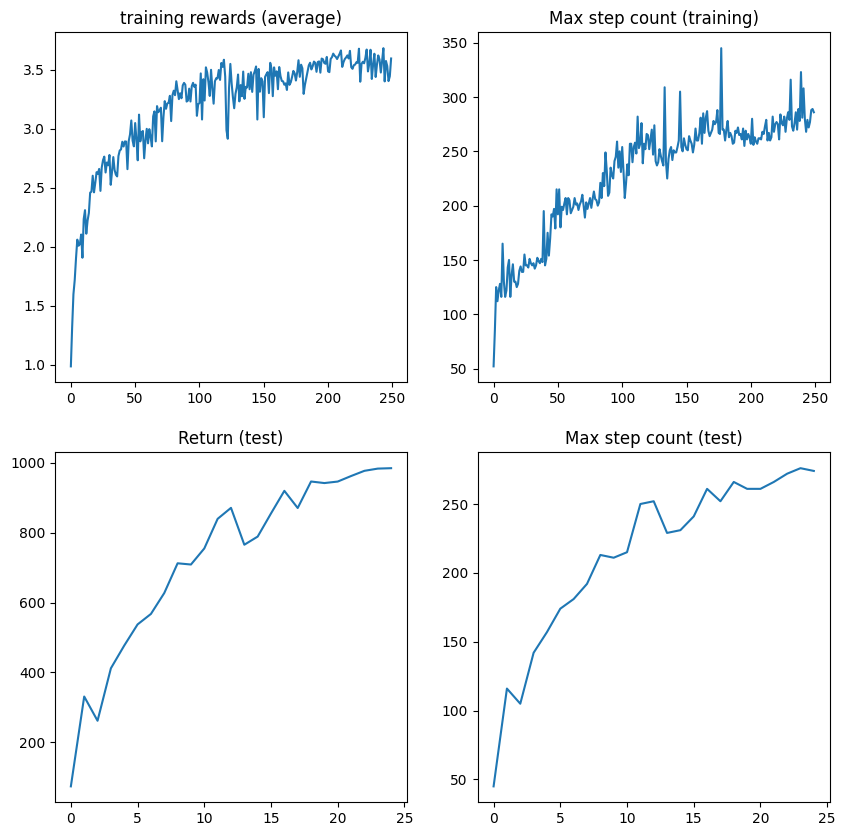

In [23]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

Conclusion and next steps
=========================

In this tutorial, we have learned:

1.  How to create and customize an environment with
    :py`torchrl`{.interpreted-text role="mod"};
2.  How to write a model and a loss function;
3.  How to set up a typical training loop.

If you want to experiment with this tutorial a bit more, you can apply
the following modifications:

-   From an efficiency perspective, we could run several simulations in
    parallel to speed up data collection. Check
    `~torchrl.envs.ParallelEnv`{.interpreted-text role="class"} for
    further information.
-   From a logging perspective, one could add a
    `torchrl.record.VideoRecorder`{.interpreted-text role="class"}
    transform to the environment after asking for rendering to get a
    visual rendering of the inverted pendulum in action. Check
    :py`torchrl.record`{.interpreted-text role="mod"} to know more.


# Rendering

import os
os.environ["MUJOCO_GL"] = "egl"

In [24]:
import time

# Create an environment with rendering enabled
render_env = GymEnv("Hopper-v4", device=device, render_mode="human")

# Reset environment
tensordict = render_env.reset()
done = False

# Execute policy in a loop
with torch.no_grad():
    while not done:
        tensordict["observation"] = tensordict["observation"].to(torch.float32)  # Convert dtype
        action = policy_module(tensordict)  # Get action from trained policy
        tensordict = render_env.step(action)  # Step in environment
        render_env.render()  # Render environment
        time.sleep(0.02)  # Add a small delay for smooth visualization
        done = tensordict["done"].item()  # Check if episode is over

# Close environment
render_env.close()


eval cumulative reward:  984.7977 (init:  73.8822), eval step-count: 274, average reward= 3.5958 (init= 0.9850), step count (max): 286, lr policy:  0.0000: 100%|██████████| 250000/250000 [09:00<00:00, 477.64it/s]

KeyboardInterrupt: 

# From there it doesn't work but i want to keep it for later

In [ ]:
import time
from tensordict import TensorDict
from torchrl.envs import TransformedEnv, Compose, DoubleToFloat, ObservationNorm
import torch  # Ensure torch is imported

# Create render_env without StepCounter()
render_env = TransformedEnv(
    GymEnv("Hopper-v4", device=device, render_mode="human"),
    Compose(
        ObservationNorm(in_keys=["observation"]),  # Ensure same normalization
        DoubleToFloat(),  # Ensure dtype is float32
    ),
)

# Copy normalization stats from `env` (not `base_env`) to `render_env`
render_env.transform[0].loc = env.transform[0].loc
render_env.transform[0].scale = env.transform[0].scale

# Reset environment
tensordict = render_env.reset()
print("Available keys in TensorDict after reset:", tensordict.keys())  # Debugging

done = False

# Run trained policy
with torch.no_grad():
    while not done:
        # Fix missing observation key
        obs_key = "observation" if "observation" in tensordict.keys() else "next"
        tensordict["observation"] = tensordict.get(obs_key).to(torch.float32)

        action = policy_module(tensordict)  # Get action from trained policy

        # Extract action correctly
        action = action["action"]

        # Wrap action in a proper TensorDict
        tensordict = render_env.step(TensorDict({"action": action}, batch_size=[]))

        # Debugging: Print available keys
        print("Available keys in TensorDict after step:", tensordict.keys())

        render_env.render()  # Render environment
        time.sleep(0.02)  # Small delay for smooth visualization

        # Ensure `done` is a Tensor before calling .item()
        done = tensordict.get("done", tensordict.get("terminated", tensordict.get("truncated", torch.tensor(False))))
        done = done.item() if isinstance(done, torch.Tensor) else done  # Fixed

# Close environment
render_env.close()